In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn theme
sns.set_theme()

excel_path = 'data/SD Feb-May 2019.xlsx'

# Brign forth the Feb-Mar sheet data
df_feb_may = pd.read_excel(excel_path, sheet_name='Feb-Mar')

# Bring forth the Apr-May sheet data
df_abr_may = pd.read_excel(excel_path, sheet_name='Abr-May')

# Concatenate the two dataframes

df = pd.concat([df_feb_may, df_abr_may])

df.index = pd.to_datetime(df['fecha_completa'], format='Y-%m-%d %H:%M:%S')

In [4]:

def extract_transform_load(df: pd.DataFrame):
    """
    Extracts, transforms, and loads data for entry/exit analysis.

    Args:
        df (pd.DataFrame): Input DataFrame containing access data.

    Returns:
        pd.DataFrame, pd.DataFrame: DataFrames containing entries and exits data.
    """
    # Data Cleaning & Preparation
    df_filtered = (
        df.drop(columns=["PORTERIA", "RESULTADO_EVENTO", "ROL"])
        .query("MODO_ACCESO == 'Peatonal'")
        .drop(columns=["MODO_ACCESO"])
    )
    df_filtered["TIPO_ACCESO"] = df_filtered["TIPO_ACCESO"].str.strip()
    df_filtered["DIA"] = pd.to_numeric(df_filtered["DIA"])
    df_filtered.set_index(pd.to_datetime(df_filtered.index), inplace=True)

    # Add day of the week
    df_filtered['day_of_week'] = df_filtered.index.day_name()
    
    # Order day of the week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df_filtered['day_of_week'] = pd.Categorical(df_filtered['day_of_week'], categories=day_order, ordered=True)

    # Add week number
    df_filtered['week'] = df_filtered.index.isocalendar().week

    # Separate Entries and Exits
    df_in = df_filtered[df_filtered["TIPO_ACCESO"] == "IN"]
    df_out = df_filtered[df_filtered["TIPO_ACCESO"] == "OUT"]

    return df_in, df_out



def entry_exit_day_of_month(df: pd.DataFrame):
    """
    Extracts, transforms, and loads data for entry/exit analysis.

    Args:
        df (pd.DataFrame): Input DataFrame containing access data.

    Returns:
        alt.Chart: Altair chart object visualizing entries and exits per day.
    """

    # Data Cleaning & Preparation

    [df_in, df_out] = extract_transform_load(df)

    df_in_day = df_in.groupby(["MES", "DIA"]).size().reset_index(name="Entries")
    df_out_day = df_out.groupby(["MES", "DIA"]).size().reset_index(name="Exits")

    # Extract day of the month using the MultiIndex
    df_in_day['DAY'] = df_in_day['DIA']
    df_out_day['DAY'] = df_out_day['DIA']

    # add to the month the prefix Entry or exit such it looks like "Entry - February"
    df_in_day['MES'] = "Entry - " + df_in_day['MES']
    df_out_day['MES'] = "Exit - " + df_out_day['MES']

    # Drop the columns ('MES', 'DIA') from both df_in_day and df_out_day
    df_in_day = df_in_day.drop(columns=["DIA"])
    df_out_day = df_out_day.drop(columns=["DIA"])

    return df_in_day, df_out_day

def entry_exit_day_of_week(df: pd.DataFrame):
    """
    Extracts, transforms, and loads data for entry/exit analysis by day of the week.

    Args:
        df (pd.DataFrame): Input DataFrame containing access data.

    Returns:
        pd.DataFrame, pd.DataFrame: DataFrames containing grouped entries and exits by day of the week.
    """
    # Data Cleaning & Preparation
    df_in, df_out = extract_transform_load(df)
    df_in_week = df_in.groupby(['week', 'day_of_week']).size().reset_index(name='Entries')
    df_out_week = df_out.groupby(['week', 'day_of_week']).size().reset_index(name='Exits')

    return df_in_week, df_out_week



def plot_entry_exit_per_day_of_month(df_in_day: pd.DataFrame, df_out_day: pd.DataFrame, palette: dict = None):
    """
    Plots the number of entries and exits per day.

    Args:
        df_in_day (pd.DataFrame): DataFrame containing entries per day.
        df_out_day (pd.DataFrame): DataFrame containing exits per day.

    Returns:
        None
    """

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the entries it should plot the entries per day and diferentiate by a hue applied to the month
    sns.lineplot(data=df_in_day, x="DAY", y="Entries", hue="MES", marker="o", palette=palette['Entries'], ax=ax)

    # Plot the exits it should plot the exits per day and diferentiate by a hue applied to the month

    sns.lineplot(data=df_out_day, x="DAY", y="Exits", hue="MES", marker="o", palette=palette['Exits'], ax=ax)

    # Set the title of the plot

    plt.title("Number of Entries and Exits per Day")

    # Set the x-axis label
    plt.xlabel("Day")

    # Set the y-axis label

    plt.ylabel("Number of Entries/Exits")
    plt.show()

def plot_entry_exit_per_day_of_week(df_in_week: pd.DataFrame, df_out_week: pd.DataFrame, palette: dict = None):
    """
    Plots the number of entries and exits per day of the week.

    Args:
        df_in_week (pd.DataFrame): DataFrame containing entries per day of the week.
        df_out_week (pd.DataFrame): DataFrame containing exits per day of the week.

    Returns:
        None
    """
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the entries per day of the week
    sns.lineplot(data=df_in_week, x='day_of_week', y='Entries', hue='week', marker='o', palette=palette['Entries'], ax=ax)

    # Plot the exits per day of the week
    sns.lineplot(data=df_out_week, x='day_of_week', y='Exits', hue='week', marker='o', palette=palette['Exits'], ax=ax)

    # Set the title of the plot
    plt.title("Number of Entries and Exits per Day of the Week")

    # Set the x-axis label
    plt.xlabel("Day of the Week")

    # Set the y-axis label
    plt.ylabel("Number of Entries/Exits")
    plt.show()


In [5]:

palette = {"Entries": sns.color_palette("Blues", 4), "Exits": sns.color_palette("Reds", 4)}
[df_in_day, df_out_day] = entry_exit_day_of_month(df)
plot_entry_exit_per_day_of_month(df_in_day, df_out_day, palette)

KeyError: "['BADGEID'] not found in axis"

/tmp/ipykernel_84403/2796423408.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_in_week = df_in.groupby(['week', 'day_of_week']).size().reset_index(name='Entries')
/tmp/ipykernel_84403/2796423408.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_out_week = df_out.groupby(['week', 'day_of_week']).size().reset_index(name='Exits')


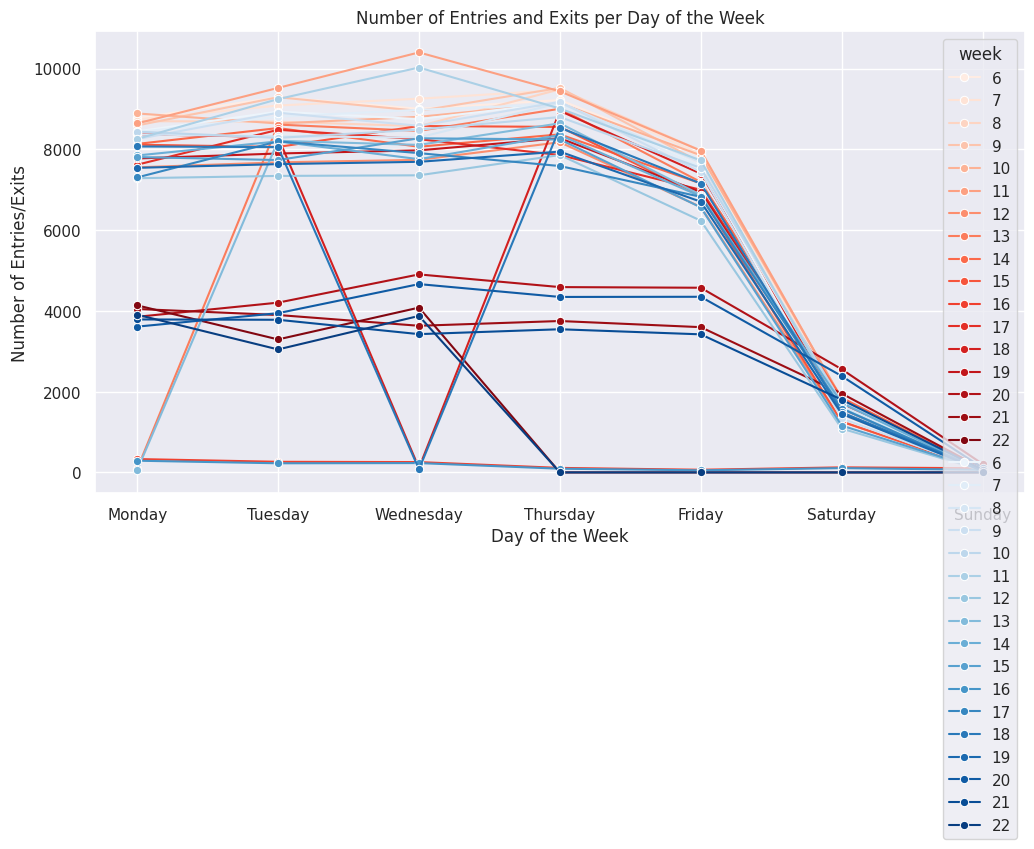

In [37]:
# Day of the week

[df_in_week, df_out_week] = entry_exit_day_of_week(df)

palette = {"Entries": sns.color_palette("Reds", 17), "Exits": sns.color_palette("Blues", 17)}
plot_entry_exit_per_day_of_week(df_in_week, df_out_week, palette)